In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
from time import sleep

In [2]:
class Particle:
    
    def __init__(self,r0,v0,a0,t,m=1,radius=2.0,Id=0):
        
        self.dt = t[1] - t[0]
        
        self.r = r0
        self.v = v0
        self.p = m*self.v
        self.a = a0
        self.f = a0/m
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.P = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        self.F = np.zeros_like(self.R)
        # Vector normal
        self.n = np.zeros_like(self.r)
        self.N = np.zeros_like(self.R)
        
        self.Ek = np.zeros(len(t))
        
        self.radius = radius
        self.m = m
        self.K = 100.
        self.Id = Id
        
    def Evolution(self,i):
        
        self.SetPosition(i)
        self.SetVelocity(i)
        self.SetMomentum(i)
        self.SetForce(i)
        self.SetNormal(i)
        
        self.a = self.f/self.m
        
        self.r += self.dt*self.v
        self.v += self.dt*self.a
        
    def CalculateForce(self, p):
        
        d = np.linalg.norm(self.r-p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion > 0:
            
            Fn = self.K * compresion**3
            self.n = (self.r - p.r)/d
            self.f =  Fn*self.n
               
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
        self.n[:] = 0.
        
    def SetPosition(self,i):
        self.R[i] = self.r
        
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.Ek[i] = 0.5*self.m*np.dot(self.v,self.v)
        
    def SetMomentum(self,i):
        self.P[i] = self.m*self.v
        

    def GetVelocity(self,scale=1):
        return self.V[::scale]
    
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetEnergy(self,scale=1):
        return self.Ek[::scale]    
    
    def SetForce(self,i):
        self.F[i] = self.f

    def GetForce(self):
        return self.F[::scale]
    
    def SetNormal(self,i):
        self.N[i] = self.n 
    
    def GetNormal(self,scale):
        return self.N[::scale]
            
    def CheckLimits(self,Limits):
        
        for i in range(2):
        
            if self.r[i] + self.radius > Limits[i][1] and self.v[i] > 0.:
                self.v[i] = -1.0*self.v[i]
            if self.r[i] - self.radius < Limits[i][0] and self.v[i] < 0.:
                self.v[i] = -1.0*self.v[i]

In [3]:
def RunSimulation1(t,Wall):
    
    r0 = np.array([-5.,1.])
    v0 = np.array([10.,0.])
    a0 = np.array([0.,0])
    
    r1 = np.array([0.,0.])
    v1 = np.array([0.,0.])
    a1 = np.array([0.,0.])
    
    
    p1 = Particle(r0,v0,a0,t,m=1,radius=2,Id=0)
    p2 = Particle(r1,v1,a1,t,m=1,radius=2,Id=1)
    #p3 = Particle(np.array([4.,4.]),np.array([-6.,-4.]),a1,t,m=4,radius=2,Id=2)
    
    Wall_ = Wall.copy()
    
    Particles = [p1,p2]
    
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps'):
        sleep(0.0001)
        
        
        # Primero calculamos fuerzas sobre todas las particulas i!=j
        for i in range(len(Particles)): 
            for j in range(len(Particles)):
                if i != j:
                    Particles[i].CalculateForce(Particles[j])
                    #print(i,j)
                    
        # Evolucionamos y reiniciamos la fuerza
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits(Wall_)
    
    return Particles

In [4]:
# Region
Limits = np.array([[-20.,20.],[-20.,20.]])
Limits

array([[-20.,  20.],
       [-20.,  20.]])

In [5]:
# So expensive
dt = 0.0001
tmax = 1
t = np.arange(0.,tmax,dt)
Particles = RunSimulation1(t,Limits)

Running simulation: 100%|███████████████████████████████| 10000/10000 [00:04<00:00, 2227.70 Steps/s]


In [6]:
scale = 100

In [7]:
t = t[::scale]

<IPython.core.display.Javascript object>


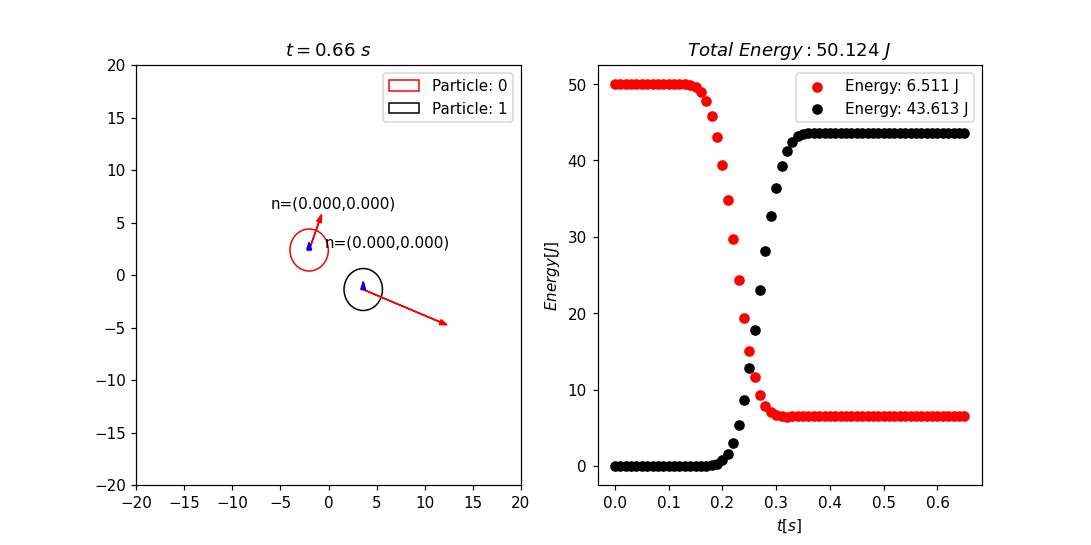

In [12]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

colors=['r','k','g']

def init():
    
    ax.clear()
    ax1.clear()
    ax.set_xlim(Limits[0][0],Limits[0][1])
    ax.set_ylim(Limits[1][0],Limits[1][1])
    
    ax1.set_xlabel(r'$t[s]$')
    ax1.set_ylabel(r'$Energy[J]$')
    
def Update(i):
    
    ax.clear()
    init()
    ax.set_title(r'$ t=%.2f \ s$' %(t[i]))
    
    j=0
    TotalE=0
    for p in Particles:
    
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        n = p.GetNormal(scale)[i]
    
        circle = plt.Circle((x,y),p.radius, fill=False, color=colors[j],label='Particle: '+str(p.Id))
        ax.add_patch(circle)
    
        ax.arrow(x,y,vx,vy,color='r',head_width=0.5,length_includes_head=True)
        
        # Pintamos vector normal
        ax.arrow(x,y,n[0],n[1],color='b',head_width=0.5)
        
        ax.text(x-2*p.radius,y+2*p.radius,'n=({:.3f},{:.3f})'.format(n[0],n[1]))
        
        
        TotalE += p.GetEnergy(scale)[i]
        ax1.set_title(r'$Total \ Energy: {:.3f} \ J$'.format(TotalE))
        ax1.scatter(t[:i],p.GetEnergy(scale)[:i],color=colors[j],label='Energy: %.3f J' %(p.GetEnergy(scale)[i]))
        j += 1
      
    ax.legend()
    ax1.legend()
    
    
    
Animation = anim.FuncAnimation(fig,Update,frames=len(t),init_func=init)

<IPython.core.display.Javascript object>


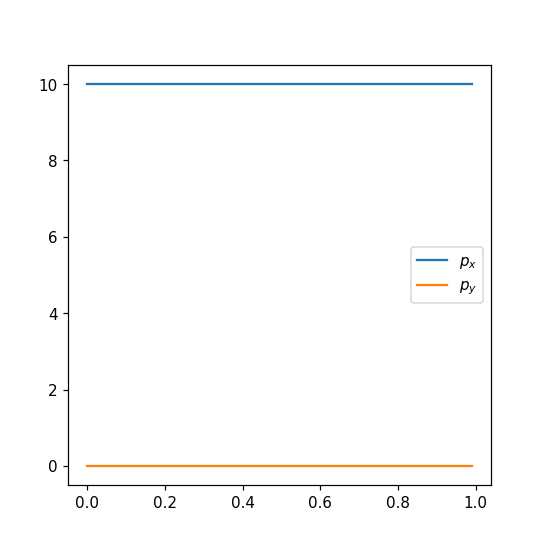

In [9]:
fig3 = plt.figure(figsize=(5,5))
ax3 = fig3.add_subplot(111)
Momentum = Particles[0].GetMomentum(scale)

for i in range(1,len(Particles)):
    Momentum = np.add(Momentum, Particles[i].GetMomentum(scale)) # Total momentum
ax3.plot(t,Momentum[:,0],label=r'$p_{x}$')
ax3.plot(t,Momentum[:,1],label=r'$p_{y}$')
ax3.legend()

In [10]:
Writer = anim.writers['ffmpeg']
fps = (1./dt) / scale
writer_ = Writer(fps=fps, metadata=dict(artist='Me'))
#Animation.save('Particula.mp4', writer=writer_)

In [11]:
#del Particles